In [ ]:
suppressPackageStartupMessages(library(dplyr))
library(ggplot2)
library(ggrepel)
library(patchwork)
library(pheatmap)
library(RColorBrewer)
suppressPackageStartupMessages(library(Seurat))
source("/projects/ps-renlab2/y2xie/scripts/Paired-HiC/phc_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/basics.R")

## Compare correlation in match versus unmatched groups: Paried-HiC and Droplet HiC (Fig.2D)

In [15]:
### Select abundant cell type to compare
pmeta <- read.table("FC_phc_HiC_240101_DPT_anno_cluster_allcells.info.txt", header = T)
ct_remove <- table(pmeta$cluster) %>%
as.data.frame %>%
dplyr::filter(Freq < 500) %>%
dplyr::select(Var1) %>% unlist

### Select bin with most variable genes!
suppressPackageStartupMessages(library(GenomicRanges))
library(Seurat)

obj <- readRDS("/projects/ps-renlab/y2xie/projects/scifi-multiome/28.FC_16k_Droplet_PT_221210/05.R/seurat_object/FC_RNA_Seurat_merged_rmScrublet_221229.rds")
mm10 <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/mm10/mm10.gcode.vm25.bed")
mm10_genes.gr = GRanges(mm10[, 1], IRanges::IRanges(mm10[, 2], mm10[, 3]), gene = mm10[,5])
qry <- mm10 %>% filter(V5 %in% VariableFeatures(obj))
qry.gr <- GRanges(qry[, 1], IRanges::IRanges(qry[, 2], qry[, 3]), gene = qry[,5])

qry.bin <- qry.gr %>%
as.data.frame %>%
mutate(startb = floor(start / 100000), endb = ceiling(end / 100000)) %>%
dplyr::select(c(seqnames, startb, endb)) %>%
distinct

### coarse into 100kb bin
split_rows <- function(c, a, b) {
  if (b - a > 1) {
    num_rows <- b - a
    new_rows <- data.frame(seqnames = rep(c, times = num_rows), startb = a:(b-1), endb = (a+1):b)
    return(new_rows)
  } else {
    return(data.frame(seqnames = c, startb = a, endb = b))
  }
}

# Apply the function row-wise using dplyr
result <- qry.bin %>%
rowwise() %>%
do(split_rows(.$seqnames, .$startb, .$endb)) %>%
ungroup()

valid_bin <- result %>% 
distinct %>%
mutate(start = 100000*startb, end = 100000*endb) %>%
mutate(bin = paste0(seqnames, ":", as.integer(start), "-", as.integer(end))) %>%
dplyr::select(bin) %>% unlist

Using id as id variables



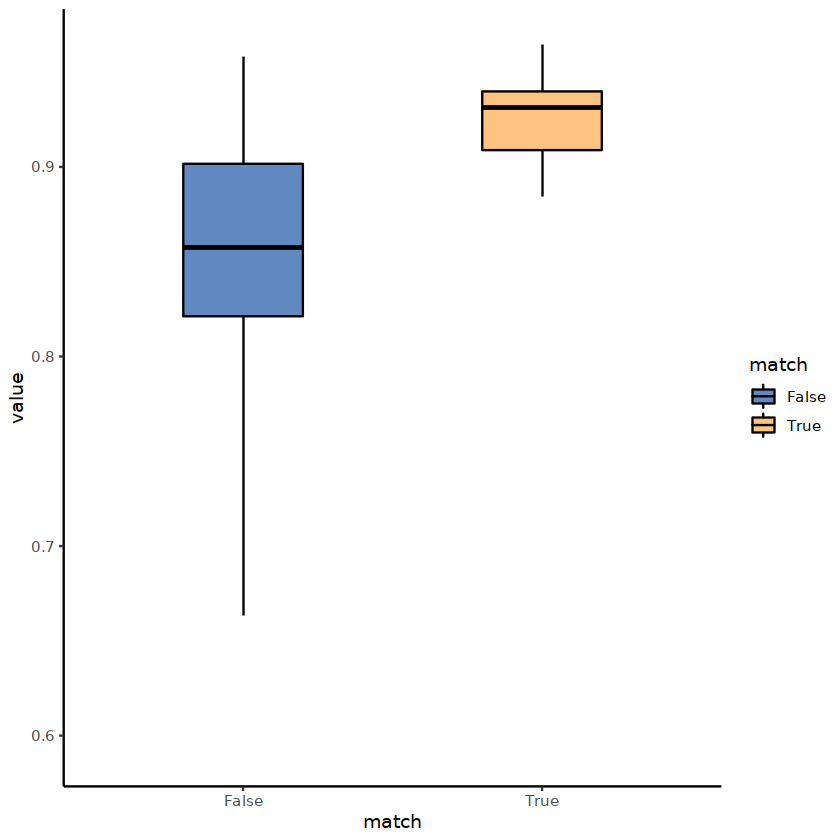

In [195]:
phc <- "../04.matrices/FC_phc_240101/compartment/comp_raw_LC462_raw_pca.csv"
schic <- "../../62.schiC_MouseCortex_NovaSeq_230723/04.matrices/mFC_240101_DPT_rna_annotate/compartment/comp_merge_raw_pca.csv"

phc <- read.csv(phc, header = T, row.names = 1)
tmpname <- rownames(phc) %>% stringr::str_split_fixed(pattern = "-", n = 2) %>% as.data.frame %>%
mutate(start = 100000*as.integer(V2), end = 100000*(as.integer(V2) + 1)) %>%
mutate(bin = paste0(V1, "-", as.integer(start), "-", as.integer(end)))
rownames(phc) <- tmpname$bin

schic <- read.csv(schic, header = T, row.names = 1, sep = "\t")

### fetch variable bins only
valid_bin <- result %>% 
distinct %>%
mutate(start = 100000*startb, end = 100000*endb) %>%
mutate(bin = paste0(seqnames, "-", as.integer(start), "-", as.integer(end))) %>%
dplyr::select(bin) %>% unlist

share_bin <- intersect(intersect(rownames(phc), rownames(schic)), valid_bin)

rmat <- cor(phc[share_bin, !(colnames(phc) %in% ct_remove)], 
            schic[share_bin, !(colnames(schic) %in% ct_remove)], method = "spearman")

rmat <- rmat %>% as.data.frame %>%
tibble::rownames_to_column("id") %>%
reshape2::melt() %>%
setNames(c("Var1", "Var2", "value"))

t1 <- rmat %>%
mutate(match = ifelse(Var1 == Var2, "True", "False")) %>%
# dplyr::filter(!(Var1 %in% c("CLAGL", "VLMC", "PTGL")) & !(Var2 %in% c("CLAGL", "VLMC", "PTGL"))) %>%
ggplot(aes(x = match, y = value, fill = match)) + 
geom_boxplot(width = 0.4, color = "black", alpha = 0.8, coef = 2, outlier.shape = NA) + 
theme_classic() + 
scale_fill_Publication()

t1

# ggsave(t1, filename = "plot/phc_impute_cor_with_droplethic_match.pdf", dpi = 300, height = 6, width = 6)
# write.table(t1$data, "source_data/phc_impute_cor_with_droplethic_match.txt", sep = "\t", quote = F)

## Plot gene expression associated with Hi-C contacts difference (Fig.6C)

In [81]:
mmg <- readRDS("seurat_object/FC_phc_RNA_rmDoublet_230728.rds")
t1 <- VlnPlot(mmg, "Erbb4", group.by = "predicted.id", pt.size = 0)
t1 <- t1$data %>% filter(ident %in% c('PVGA', 'VIPGA', 'OPC', 'ITL23GL')) %>%
mutate(ident = factor(ident, levels = c('PVGA', 'VIPGA', 'OPC', 'ITL23GL'))) %>% 
ggplot(aes(x = ident, y = Erbb4)) + 
geom_violin(alpha = 0.8, aes(fill = ident)) + 
geom_boxplot(width = 0.1, color = "black", alpha = 0.8, coef = 2, outlier.shape = NA) + 
xlab("") + 
theme_classic() + 
scale_fill_manual(values = c("#377549", "#3C81BB", "#B9A0D6", "#E59D9F")) + NoLegend()

ggsave(t1, filename = "FC_phc_RNA_rmDoublet_Erbb4_vln_240101.pdf", dpi = 300, height = 6, width = 5)

## Cor between compartment and gene expression (Fig.6E)

In [ ]:
rna <- read.csv("FC_phc_RNA_rmDoublet_annot_clean_240101_DPT_anno_RNA_RPKM.csv", row.names = 1)
corder <- c("ASC", "OGC", "OPC", "MGL", 
            "ITL23GL", "ITL45GL", "ITL5GL", "ITL6GL", "CTGL", "NPGL", "OBGL",
            "D12MSN", "PVGA", "VIPGA", "SSTGA", "STRGA", "OBGA")

In [172]:
gene_length = read.table("/projects/ps-renlab/y2xie/projects/genome_ref/mm10-2020-A_build/mm10_gene_allowlist.bed")

### assign 100kb bin
table(gene_length$V6 == rownames(rna))

### need to manually match order
options(scipen = 999)
gene_length$tss_bin <- paste0(gene_length$V1, "-", as.character((gene_length$V2 %/% 100000) * 100000 + 1), "-", as.character(((gene_length$V2 %/% 100000) + 1) * 100000))
gene_length$tts_bin <- paste0(gene_length$V1, "-", as.character(((gene_length$V3 %/% 100000) - 1) * 100000 + 1), "-", as.character((gene_length$V3 %/% 100000) * 100000))
tss_bin <- gene_length[match(rownames(rna), gene_length$V6), "tss_bin"]
tts_bin <- gene_length[match(rownames(rna), gene_length$V6), "tts_bin"]


FALSE  TRUE 
   40 32245 

In [173]:
gbody_bin = list()
for (i in 1:nrow(gene_length)){
    chrom = gene_length$V1[i]
    gene = gene_length$V6[i]
    start = gene_length$V2[i]
    end = gene_length$V3[i]
    if(end - start >= 200000){
        nrange = seq(start, end, 100000)
        nbin = nrange %/% 100000
        gbody_bin[[i]] <- data.frame(gene = rep(gene, (length(nrange)-2)),
                                     chrom = rep(chrom, (length(nrange)-2)),
                                     start = nrange[2:(length(nrange)-1)],
                                     end = nrange[3:(length(nrange))],
                                     bstart = nbin[2:(length(nbin)-1)]*100000+1,
                                     bend = nbin[3:length(nbin)]*100000)
    }
}
gbody_bin <- do.call(rbind, gbody_bin)
gbody_bin$gbody_bin = paste(gbody_bin$chrom, gbody_bin$bstart, gbody_bin$bend, sep = "-")
head(gbody_bin)

,gene,chrom,start,end,bstart,bend,gbody_bin
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Xkr4,chr1,3305901,3405901,3300001,3400000,chr1-3300001-3400000
2,Xkr4,chr1,3405901,3505901,3400001,3500000,chr1-3400001-3500000
3,Xkr4,chr1,3505901,3605901,3500001,3600000,chr1-3500001-3600000
4,Rp1,chr1,4099557,4199557,4000001,4100000,chr1-4000001-4100000
5,Rp1,chr1,4199557,4299557,4100001,4200000,chr1-4100001-4200000
6,Rp1,chr1,4299557,4399557,4200001,4300000,chr1-4200001-4300000


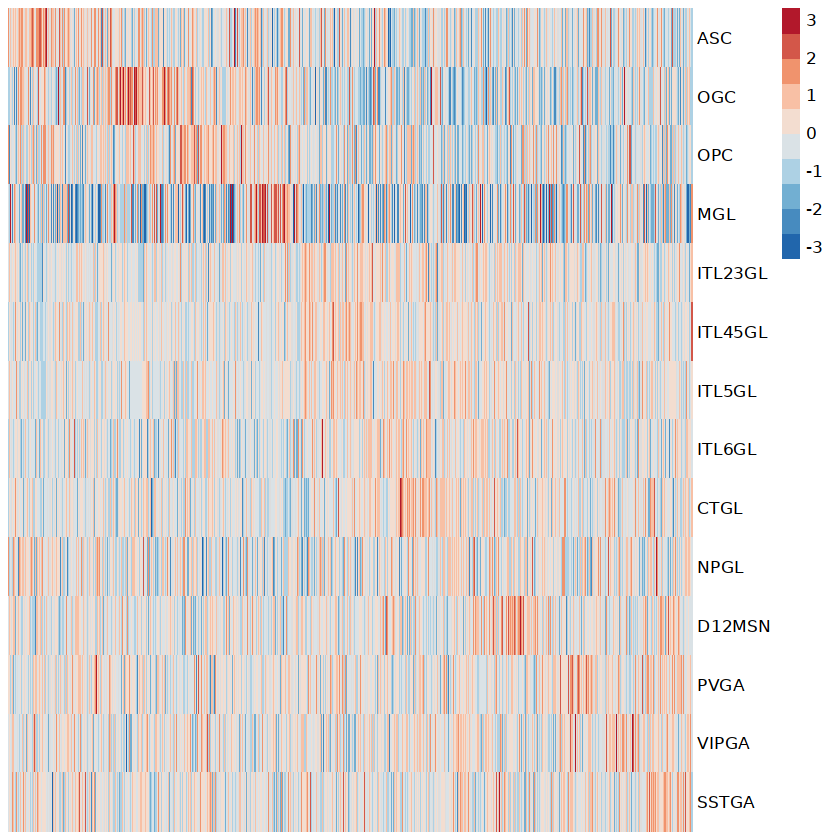

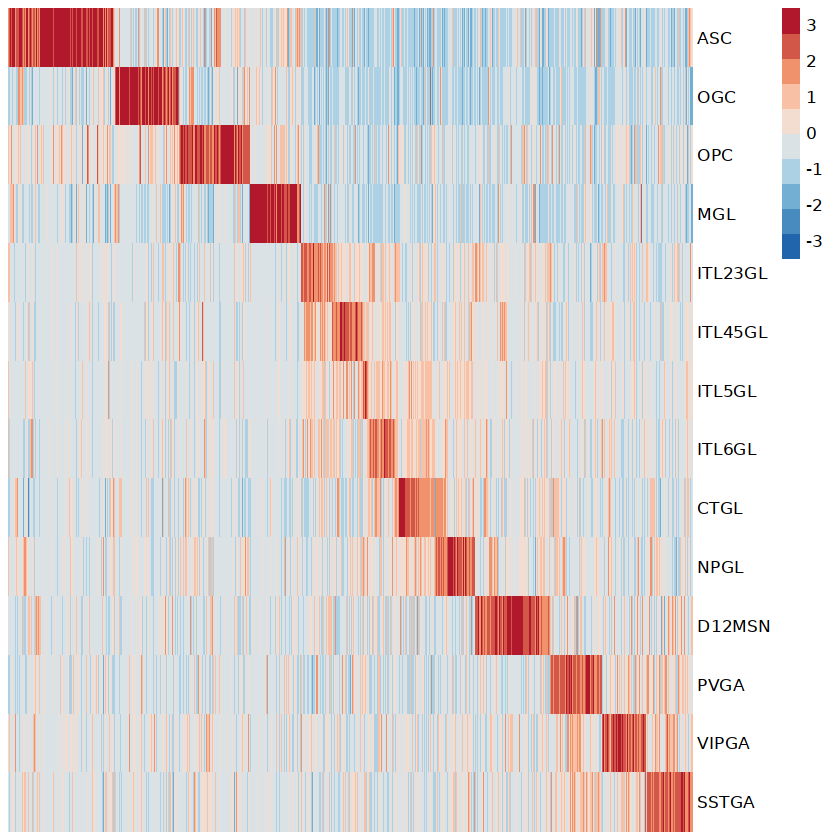

In [182]:
### focus on only DE gene bins
DE_genes <- read.table("FC_phc_RNA_rmDoublet_240101_DPT_RNA_marker.txt")
DE_genes <- DE_genes %>% dplyr::filter(p_val_adj < 0.05 & avg_log2FC > 0.58) %>% dplyr::select(gene) %>% unlist %>% unique

rmat <- rna[DE_genes, corder]
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat3 <- rmat[permutation_vector, ]

### plot gene body bin?
long_gene <- intersect(rownames(smat3), gbody_bin$gene)
DE_genes_bin <- gbody_bin[match(long_gene, gbody_bin$gene), "gbody_bin"]
DE_genes_gene <- gbody_bin[match(long_gene, gbody_bin$gene), "gene"]
t1 <- comp[DE_genes_bin, corder] %>% t %>%
pheatmap(scale = "column", cluster_rows = F, cluster_cols = F, show_colnames = F, angle = 45, 
         color = colorRampPalette(rev(brewer.pal(n = 6, name = "RdBu")))(10))

t2 <- smat3[DE_genes_gene,] %>% t %>%
pheatmap(scale = "column", cluster_rows = F, cluster_cols = F, show_colnames = F, angle = 45, 
         color = colorRampPalette(rev(brewer.pal(n = 6, name = "RdBu")))(10))

ggsave(t1, filename = "plot/FC_phc_RNA_240101_diffComp_DE_genes_gbody_bin_comp_score.pdf", 
       dpi = 300, height = 5, width = 8)
ggsave(t2, filename = "plot/FC_phc_RNA_240101_diffComp_DE_genes_gbody_gene_RPKM.pdf", 
       dpi = 300, height = 5, width = 8)